In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import statsmodels.api as sm
from sklearn.linear_model import LinearRegression

import sys
sys.path.insert(0, '../')

from portfolio import *

# Load Data

In [2]:
rets = pd.read_excel('../data/sp500_fundamentals.xlsx',sheet_name='total returns')
rets.set_index('Date',inplace=True)
signals = pd.read_excel('../data/sp500_fundamentals.xlsx',sheet_name='fundamentals')
signals.set_index('Date',inplace=True)

### Notes
- We shift X by a period so that it is lagged in the regression:
$$r_{t+1} = \alpha + \boldsymbol{\beta}' \boldsymbol{x}_t + \epsilon_{t+1}$$
- We could forecast returns or excess returns. Below we forecast total returns.
- Eliminate rows with NA values.

In [3]:
rets_spy = rets[['SPY']].dropna()
sigs_lag = signals.shift(1).dropna()
y, X = rets_spy.align(sigs_lag, join='inner',axis=0)

# Regression Forecasts

In [4]:
X1 = sm.add_constant(X[['DP']])
regDP = sm.OLS(y,X1).fit()
regDP.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    SPY   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     2.613
Date:                Thu, 22 Jul 2021   Prob (F-statistic):              0.107
Time:                        01:05:34   Log-Likelihood:                 597.92
No. Observations:                 341   AIC:                            -1192.
Df Residuals:                     339   BIC:                            -1184.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0070      0.010     -0.680      0.497      -0.027       0.013
DP             0.0083      0.005      1.616      0.107      -0.002       0.018
==============================================================================
Omnibus:                       32.422   Durbin-Watson:                   1.913
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               48.866
Skew:                          -0.631   Prob(JB):                     2.45e-11
Kurtosis:                       4.360   Cond. No.                         11.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [5]:
X1 = sm.add_constant(X[['EP']])
regEP = sm.OLS(y,X1).fit()
regEP.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    SPY   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     2.745
Date:                Thu, 22 Jul 2021   Prob (F-statistic):             0.0985
Time:                        01:05:34   Log-Likelihood:                 597.99
No. Observations:                 341   AIC:                            -1192.
Df Residuals:                     339   BIC:                            -1184.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0044      0.009     -0.518      0.605      -0.021       0.012
EP             0.0030      0.002      1.657      0.098      -0.001       0.007
==============================================================================
Omnibus:                       24.651   Durbin-Watson:                   1.922
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               35.063
Skew:                          -0.523   Prob(JB):                     2.43e-08
Kurtosis:                       4.173   Cond. No.                         18.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [6]:
X1 = sm.add_constant(X)
regALL = sm.OLS(y,X1).fit()
regALL.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    SPY   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     1.771
Date:                Thu, 22 Jul 2021   Prob (F-statistic):              0.153
Time:                        01:05:34   Log-Likelihood:                 599.28
No. Observations:                 341   AIC:                            -1191.
Df Residuals:                     337   BIC:                            -1175.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0110      0.013     -0.846      0.398      -0.037       0.015
DP             0.0069      0.005      1.309      0.191      -0.003       0.017
EP             0.0025      0.002      1.386      0.167      -0.001       0.006
US10Y         -0.0012      0.001     -0.912      0.363      -0.004       0.001
==============================================================================
Omnibus:                       27.816   Durbin-Watson:                   1.918
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               40.755
Skew:                          -0.565   Prob(JB):                     1.41e-09
Kurtosis:                       4.261   Cond. No.                         39.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Collect forecasts

### Be careful about how we line up the dates. 
The date associated with the forecasts in the table below is the date the forecast is targeting--not the date the forecast was constructed. So a forecast value with date stamp of 2021-06-30 is a forecast constructed 2021-05-31, predicting the return on 2021-06-30.

In [7]:
forecasts = pd.DataFrame()
# must shift the expanded mean to ensure it has the timing described above
forecasts['Mean'] = rets_spy.expanding().mean().shift(1)['SPY']
forecasts['DP'] = regDP.fittedvalues
forecasts['EP'] = regEP.fittedvalues
forecasts['ALL'] = regALL.fittedvalues
forecasts.dropna(inplace=True)

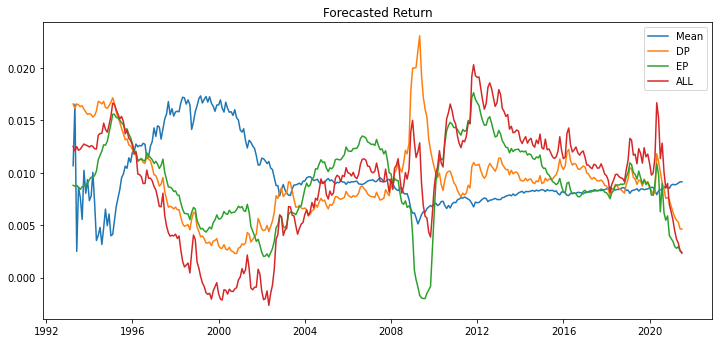

In [8]:
plot_data = forecasts
fig = plt.figure(figsize=(12,12))
plt.subplot(2, 1, 1)
plt.plot(plot_data)
plt.legend(plot_data.columns)
plt.title('Forecasted Return')
plt.show()   

# Convert Forecasts to Investment Strategy

In [9]:
def forecasts_performance(forecasts,target,adjust_vol=True):
    # Function assumes that the date on the forecasts refers to the date of the period
    # being forecast--not the date it is constructed. So a forecast value with date stamp
    # of 2021-06-30 is a forecast constructed the previous period.

    # function to translate forecasts to weights
    wts = forecasts * 100
    # by taking position proportional to forecast, we go longer when more bull-ish
    # and less long (or even short) when more bear-ish.
    
    # simulate strategy returns
    strategy = wts * target.values
    strategy.dropna(inplace=True)

    # for comparability, rescale the strategy to have same vol as passive
    if adjust_vol:
        sigma = target.std().values[0]
        strategy /= strategy.std()
        strategy *= sigma

    return strategy

In [10]:
passive, _ = rets_spy.align(forecasts,join='inner',axis=0)

funds = forecasts_performance(forecasts,passive)
funds.insert(0,'Passive', passive)

In [11]:
print('Correlation of funds performances:')
funds.corr().style.format('{:,.1%}'.format)

Correlation of funds performances:


,Passive,Mean,DP,EP,ALL
Passive,100.0%,94.2%,90.0%,87.6%,82.1%
Mean,94.2%,100.0%,74.3%,80.6%,62.8%
DP,90.0%,74.3%,100.0%,76.3%,90.4%
EP,87.6%,80.6%,76.3%,100.0%,87.9%
ALL,82.1%,62.8%,90.4%,87.9%,100.0%


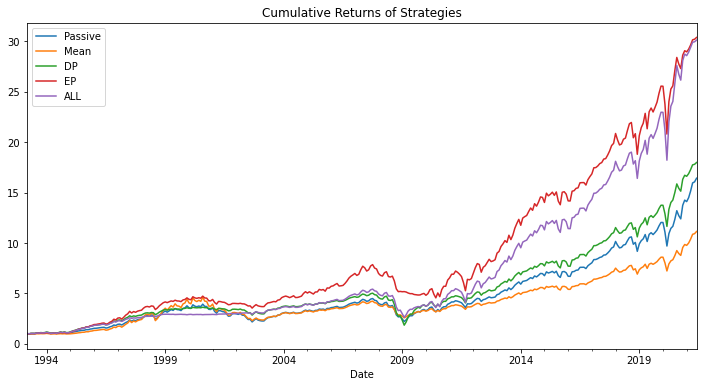

In [12]:
(funds + 1).cumprod().plot(figsize=(12,6),title='Cumulative Returns of Strategies');

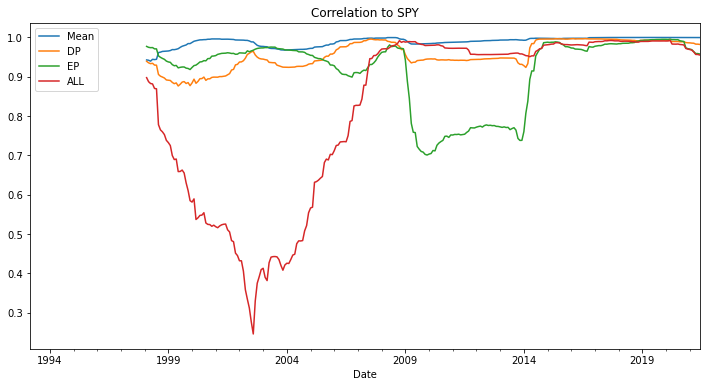

In [13]:
corr_rolling = funds.rolling(60).corr()
dynamic_corrs = (corr_rolling['Passive'].unstack(1))
dynamic_corrs = dynamic_corrs.reindex(columns=funds.columns).drop(columns=['Passive'])
dynamic_corrs.plot(figsize=(12,6),title='Correlation to SPY');

In [14]:
performanceMetrics(funds,annualization=12).style.format('{:,.2%}'.format)

,Mean,Vol,Sharpe,Min,Max,VaR (0.05),CVaR (0.05)
Passive,11.00%,14.61%,75.24%,-16.52%,12.70%,-6.95%,-9.55%
Mean,9.62%,14.61%,65.81%,-22.39%,14.72%,-6.55%,-9.46%
DP,11.32%,14.61%,77.45%,-20.89%,22.20%,-5.50%,-9.62%
EP,13.17%,14.61%,90.09%,-13.30%,21.49%,-6.03%,-8.68%
ALL,13.14%,14.61%,89.88%,-16.75%,21.76%,-6.23%,-9.52%


In [15]:
df = maximumDrawdown(funds)
df

,Max Drawdown,Peak,Bottom,Recover,Peak to Recover
Passive,-0.507980,2007-10-31,2009-02-28,2012-03-31,1613 days
Mean,-0.503254,2000-08-31,2002-09-30,2013-07-31,4717 days
DP,-0.631068,2007-10-31,2009-02-28,2012-03-31,1613 days
EP,-0.419352,2007-10-31,2010-06-30,2012-03-31,1613 days
ALL,-0.514806,2007-10-31,2009-02-28,2011-04-30,1277 days


In [16]:
df = get_ols_metrics(funds[['Passive']], funds, annualization=12)

df.style.format({
    'alpha': '{:,.2%}'.format,
    'Passive': '{:,.2f}'.format,
    'r-squared': '{:,.2%}'.format,
    'Info Ratio': '{:,.2%}'.format,
})

,alpha,Passive,r-squared,Info Ratio
Passive,-0.00%,1.00,100.00%,nan%
Mean,-0.74%,0.94,88.69%,-15.00%
DP,1.42%,0.90,80.98%,22.34%
EP,3.53%,0.88,76.79%,50.14%
ALL,4.11%,0.82,67.39%,49.23%


# OPTIONAL: Try Forecasting w/ Machine Learning Methods

### Classification And Regression Tree (CART) is a nonlinear way to build a regression

#### General, flexible model, but can be too fragile to the specific data. Accordingly, common to build many of these trees--a Random Forest--and then average over the results.

Score of Random Forest: 6.28%
Correlation between forecast and actual: 27.56%


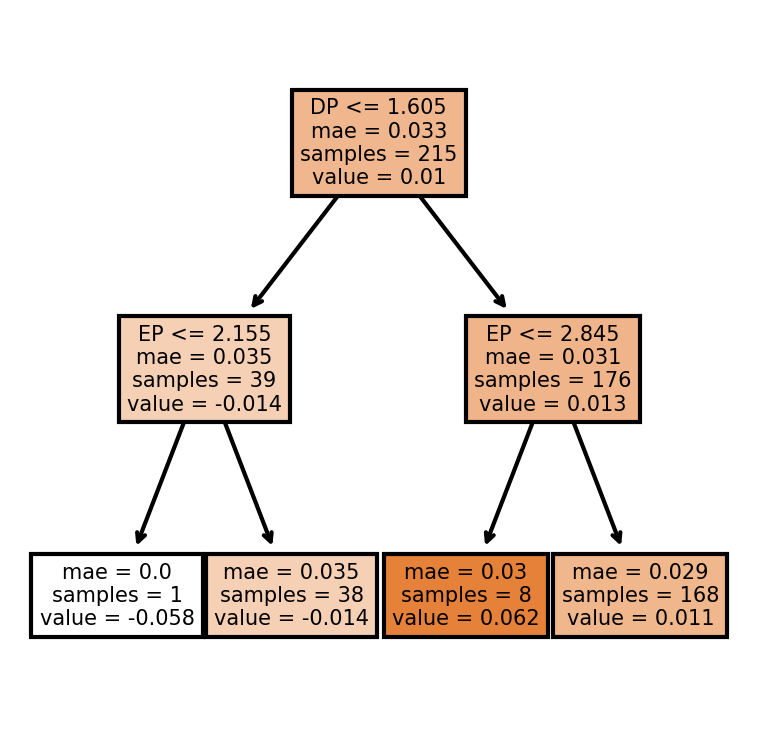

In [17]:
from sklearn.ensemble import RandomForestRegressor
from sklearn import tree

y = rets_spy.values.reshape(-1,)
XML = X[['DP','EP']]

forest = RandomForestRegressor(max_depth=2, criterion='mae',random_state=0)
forest.fit(XML,y)
predict_tree = forest.predict(XML)
print(f'Score of Random Forest: {forest.score(XML,y):0.2%}')
print(f'Correlation between forecast and actual: {np.corrcoef(y,predict_tree)[0,1]:0.2%}')

fn = XML.columns
cn = ['SPYnext']
fig, axes = plt.subplots(nrows = 1,ncols=1,figsize=(3,3), dpi=300);
tree.plot_tree(forest.estimators_[0],
              feature_names = fn,
              class_names=cn,
              filled=True);

# Let's try a Neural Network

#### We'll use a depth of 2. These hyperparameters are hard to tune, and in a more serious application we'd tune these parameters using methods such as Cross Validation. Here, we simply pick some parameters and give it a try.

In [18]:
from sklearn.neural_network import MLPRegressor

mlp = MLPRegressor(hidden_layer_sizes=(100,100),random_state=0)
mlp.fit(XML,y)

predict_nn = mlp.predict(XML)
print(f'Correlation between forecast and actual: {np.corrcoef(predict_nn,y)[0,1]:0.2%}')

Correlation between forecast and actual: 19.25%


In [19]:
forecasts_ML = pd.DataFrame(index=rets_spy.index)
forecasts_ML['Forest'] = predict_tree
forecasts_ML['NN'] = predict_nn

forecasts_ALL = pd.concat([forecasts,forecasts_ML],axis=1,join='inner')
forecasts_ALL

,Mean,DP,EP,ALL,Forest,NN
Date,,,,,,
1993-03-31,0.010667,0.016560,0.008800,0.012515,0.013668,0.002400
1993-04-30,0.016538,0.016143,0.008711,0.012095,0.013668,0.003289
1993-05-31,0.002495,0.016560,0.008800,0.012492,0.013668,0.002400
1993-06-30,0.008614,0.016477,0.008622,0.012140,0.013668,0.000696
1993-07-31,0.007625,0.016310,0.008414,0.012251,0.013668,-0.000970
...,...,...,...,...,...,...
2021-02-28,0.008842,0.005803,0.002971,0.004484,0.016712,-0.009422
2021-03-31,0.008899,0.005469,0.002792,0.003666,0.016363,-0.008728
2021-04-30,0.009007,0.005302,0.002941,0.003301,0.015864,-0.005191


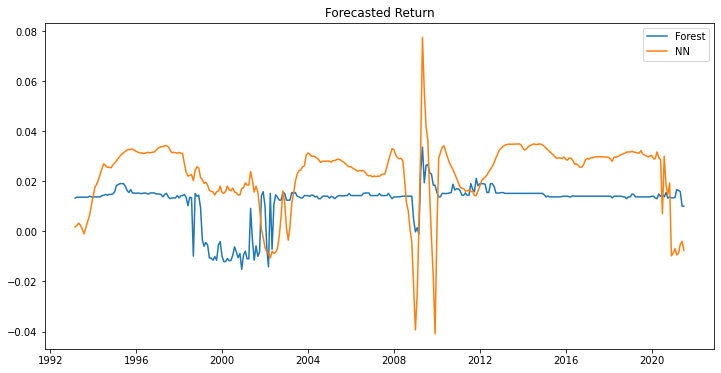

In [20]:
plot_data = forecasts_ML
fig = plt.figure(figsize=(12,6))
plt.plot(plot_data)
plt.legend(plot_data.columns)
plt.title('Forecasted Return')
plt.show()   

In [21]:
funds = forecasts_performance(forecasts_ALL,passive)
funds.insert(0,'Passive',passive)

In [22]:
print('Correlation of strategies:')
funds.corr().style.format('{:,.1%}'.format)

Correlation of strategies:


,Passive,Mean,DP,EP,ALL,Forest,NN
Passive,100.0%,94.2%,90.0%,87.6%,82.1%,73.8%,76.1%
Mean,94.2%,100.0%,74.3%,80.6%,62.8%,54.7%,72.6%
DP,90.0%,74.3%,100.0%,76.3%,90.4%,82.7%,71.6%
EP,87.6%,80.6%,76.3%,100.0%,87.9%,71.7%,74.4%
ALL,82.1%,62.8%,90.4%,87.9%,100.0%,85.2%,71.0%
Forest,73.8%,54.7%,82.7%,71.7%,85.2%,100.0%,67.8%
NN,76.1%,72.6%,71.6%,74.4%,71.0%,67.8%,100.0%


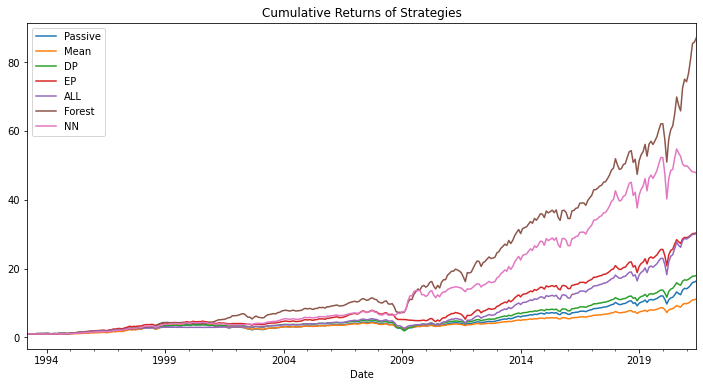

In [23]:
(funds + 1).cumprod().plot(figsize=(12,6),title='Cumulative Returns of Strategies');

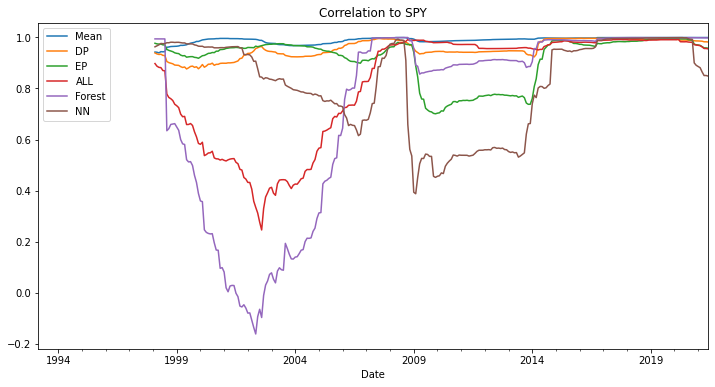

In [24]:
corr_rolling = funds.rolling(60).corr()
dynamic_corrs = (corr_rolling['Passive'].unstack(1))
dynamic_corrs = dynamic_corrs.reindex(columns=funds.columns).drop(columns=['Passive'])
dynamic_corrs.plot(figsize=(12,6),title='Correlation to SPY');

In [25]:
performanceMetrics(funds,annualization=12)

,Mean,Vol,Sharpe,Min,Max,VaR (0.05),CVaR (0.05)
Passive,0.109959,0.146147,0.752388,-0.165187,0.126984,-0.069457,-0.095510
Mean,0.096177,0.146147,0.658083,-0.223937,0.147204,-0.065544,-0.094583
DP,0.113192,0.146147,0.774511,-0.208901,0.222049,-0.055009,-0.096167
EP,0.131658,0.146147,0.900862,-0.133036,0.214881,-0.060347,-0.086765
ALL,0.131350,0.146147,0.898756,-0.167473,0.217636,-0.062283,-0.095193
Forest,0.169215,0.146147,1.157838,-0.162225,0.233486,-0.058170,-0.082135
NN,0.147609,0.146147,1.010003,-0.154135,0.299741,-0.055198,-0.081964


In [26]:
df = maximumDrawdown(funds)
df

,Max Drawdown,Peak,Bottom,Recover,Peak to Recover
Passive,-0.507980,2007-10-31,2009-02-28,2012-03-31,1613 days
Mean,-0.503254,2000-08-31,2002-09-30,2013-07-31,4717 days
DP,-0.631068,2007-10-31,2009-02-28,2012-03-31,1613 days
EP,-0.419352,2007-10-31,2010-06-30,2012-03-31,1613 days
ALL,-0.514806,2007-10-31,2009-02-28,2011-04-30,1277 days
Forest,-0.372950,2007-10-31,2009-01-31,2009-07-31,639 days
NN,-0.230247,2019-12-31,2020-03-31,2020-08-31,244 days


### Table showing performance metrics relative to regression on Passive SPY

In [27]:
df = get_ols_metrics(funds[['Passive']], funds, annualization=12)

df.style.format({
    'alpha': '{:,.2%}'.format,
    'Passive': '{:,.2f}'.format,
    'r-squared': '{:,.2%}'.format,
    'Info Ratio': '{:,.2%}'.format,
})

,alpha,Passive,r-squared,Info Ratio
Passive,-0.00%,1.00,100.00%,nan%
Mean,-0.74%,0.94,88.69%,-15.00%
DP,1.42%,0.90,80.98%,22.34%
EP,3.53%,0.88,76.79%,50.14%
ALL,4.11%,0.82,67.39%,49.23%
Forest,8.81%,0.74,54.43%,89.29%
NN,6.40%,0.76,57.86%,67.43%
